# Gel Electrophoresis Processing

In [6]:
# !copy "C:\Users\sergi\Dropbox\Camera Uploads\2022-03-10 02.36.53.jpg" C:\Users\sergi\Dropbox\workspace\Gel_Processing\data

        1 file(s) copied.


In [132]:
import skimage
import scipy
from scipy.ndimage.interpolation import shift
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
print (cv2.__version__)

4.5.5


In [5]:
gel = cv2.imread(r'F:\Dropbox\workspace\Gel_Processing_2\data\2022-03-10 02.36.53.jpg')

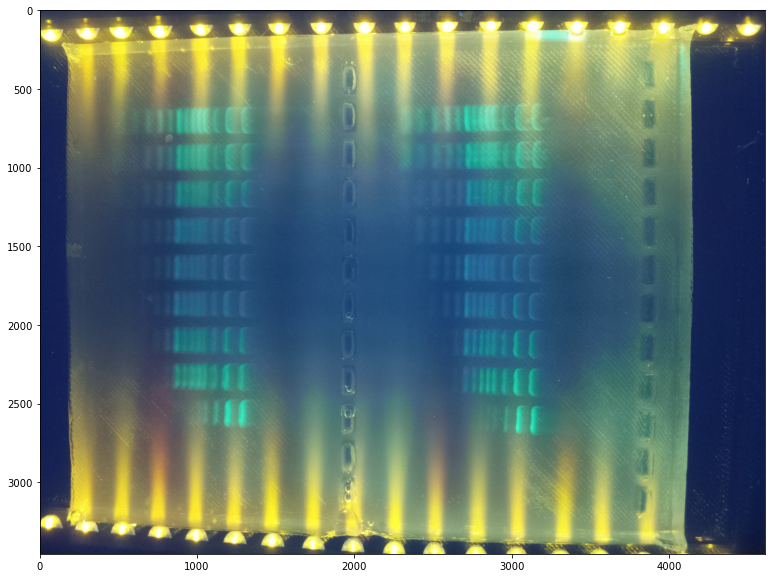

In [6]:
plt.imshow(gel)

In [7]:
gray = cv2.cvtColor(gel, cv2.COLOR_BGR2GRAY)

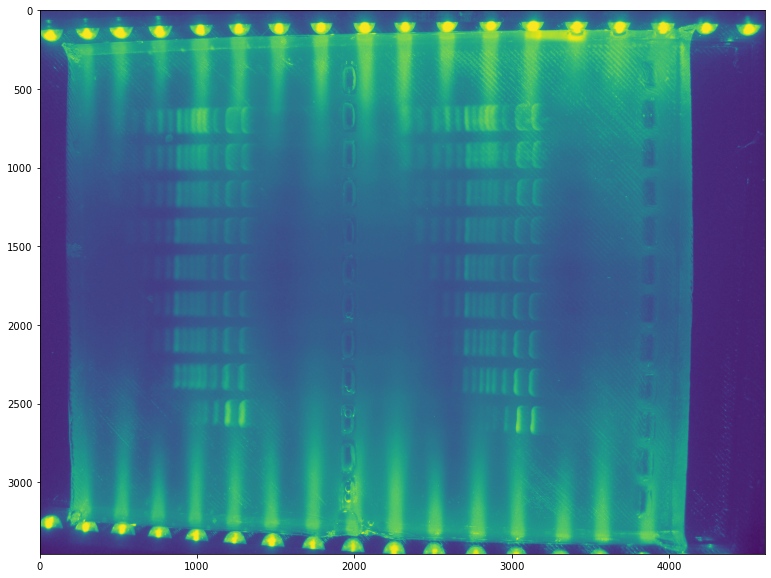

In [8]:
plt.imshow(gray)

In [9]:
gray.shape

(3456, 4608)

In [10]:
blur = cv2.GaussianBlur(gray, (9, 9), 0)

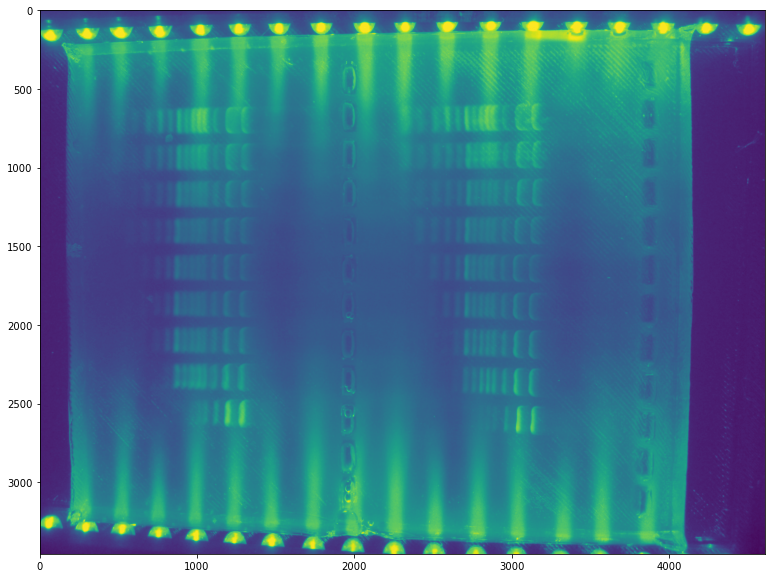

In [11]:
plt.imshow(blur)

In [12]:
mask = np.zeros(gray.shape, dtype="uint8")
roi_corners = np.array([[(160, 200), (4150, 100), (4110, 3420), (190, 3260)]], dtype=np.int32)
mask1 = cv2.fillPoly(mask, roi_corners, 255)
masked = cv2.bitwise_and(gray, mask1)

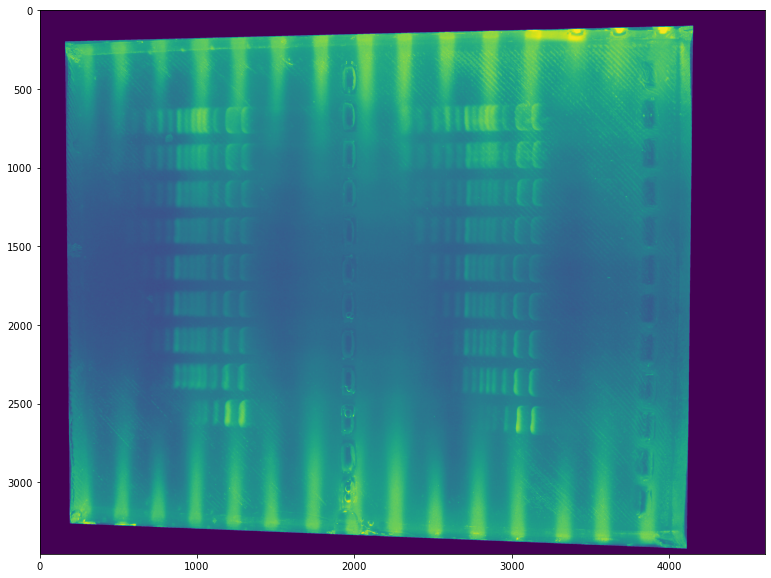

In [13]:
plt.imshow(masked)

In [14]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [15]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [16]:
transformed = four_point_transform(gel, np.array([(160, 200), (4150, 100), (4110, 3420), (190, 3260)]))

In [17]:
transformed = transformed.astype(np.int16)

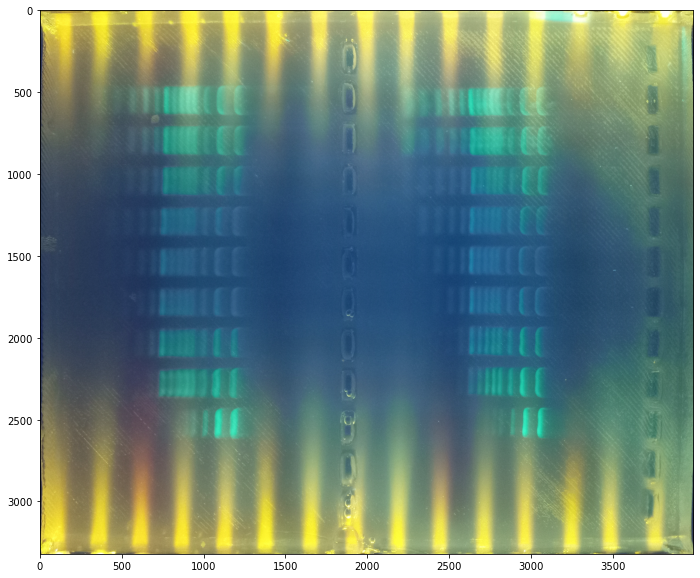

In [18]:
plt.imshow(transformed)

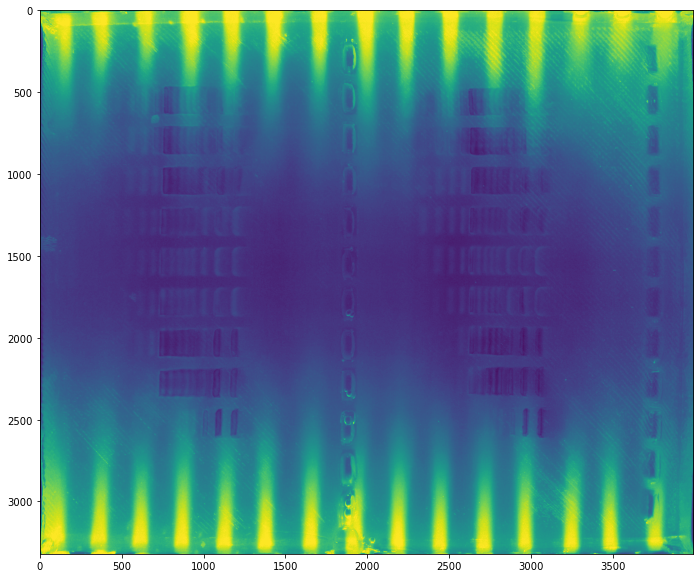

In [19]:
plt.imshow(transformed[:,:,0])

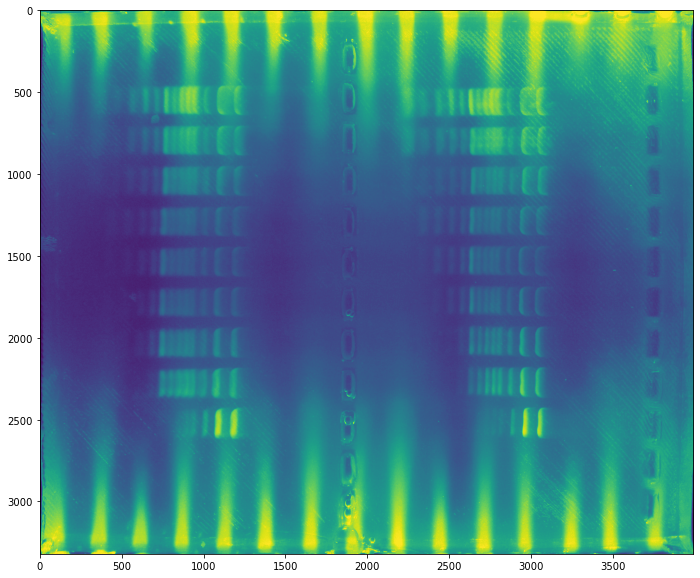

In [20]:
plt.imshow(transformed[:,:,1])

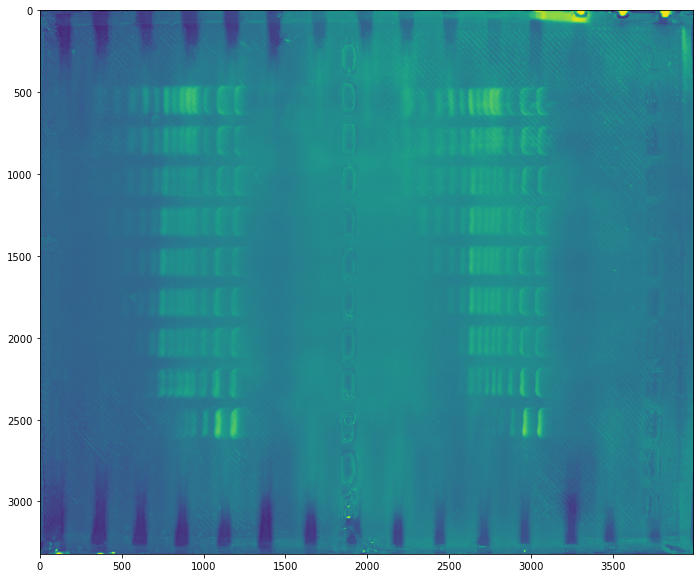

In [21]:
plt.imshow(transformed[:,:,2])

In [22]:
sample_line = transformed[200,:,0]

In [23]:
sample_line.shape

(3991,)

In [24]:
sample_line.max()

255

In [25]:
transformed[200,:,1].max()

255

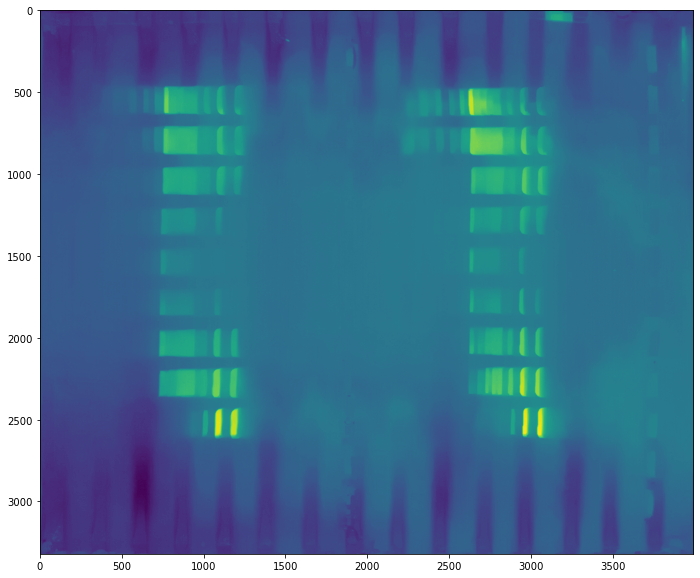

In [26]:
plt.imshow(np.subtract(transformed[:,:,1], transformed[:,:,0]))

In [27]:
bkgnd = cv2.GaussianBlur(transformed[:,:,1], (209, 2009), 0)

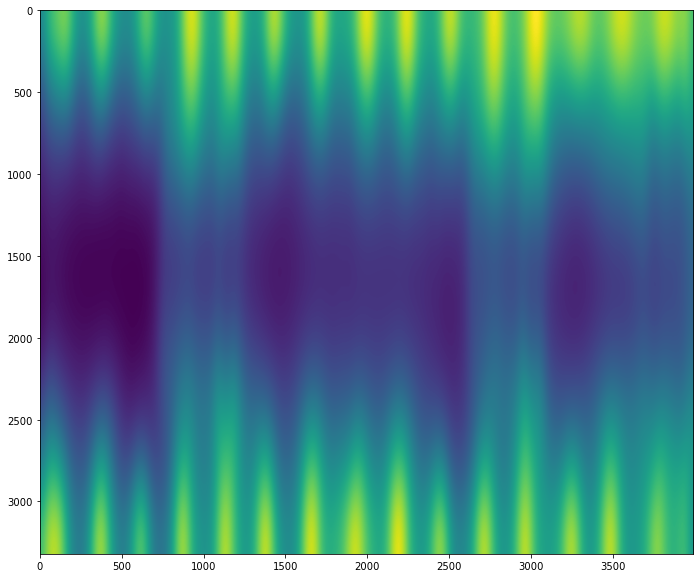

In [28]:
plt.imshow(bkgnd)

In [29]:
bkgnd2 = cv2.GaussianBlur(transformed[:,:,0], (209, 2009), 0)

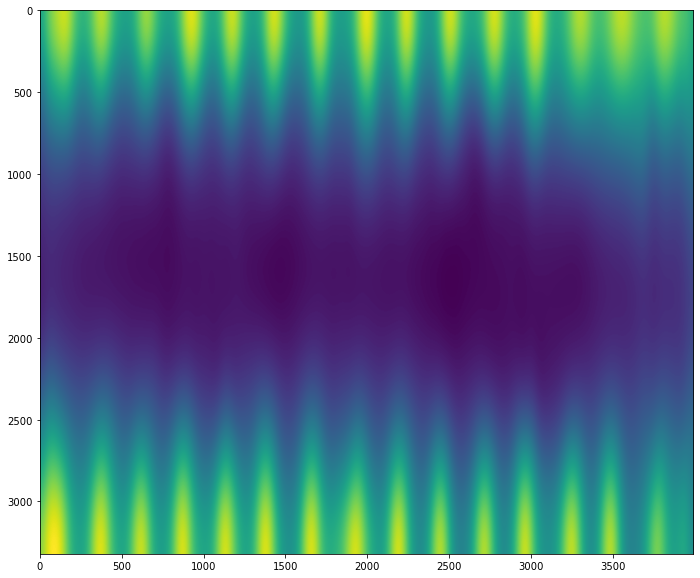

In [30]:
plt.imshow(bkgnd2)

In [31]:
subtr1 = transformed[:,:,1] - bkgnd

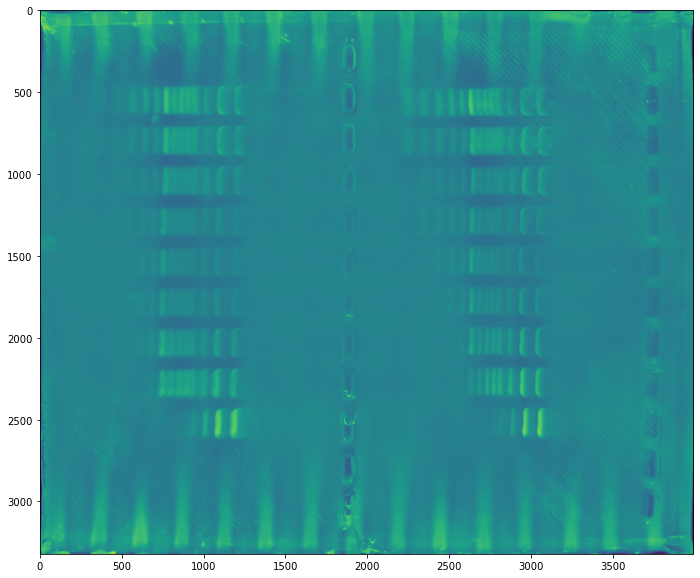

In [32]:
plt.imshow(subtr1)

In [33]:
subtr1 = transformed[:,:,1] - bkgnd2

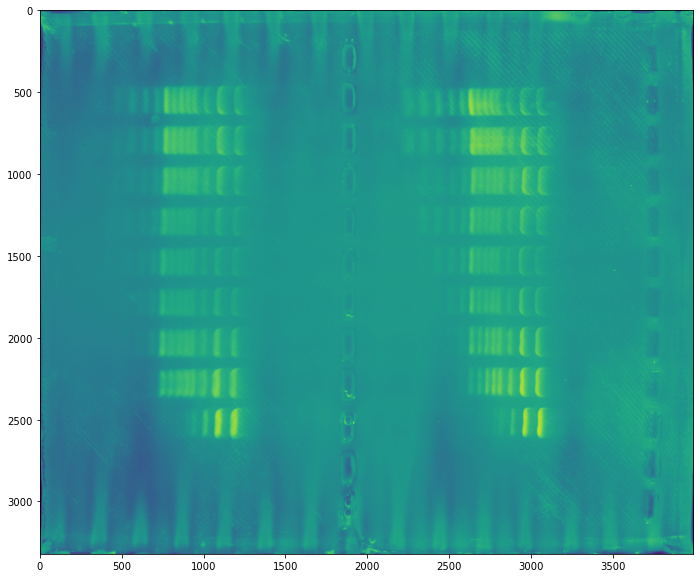

In [34]:
plt.imshow(subtr1)

In [35]:
bkgnd2 = cv2.GaussianBlur(subtr1, (2001, 2001), 0)

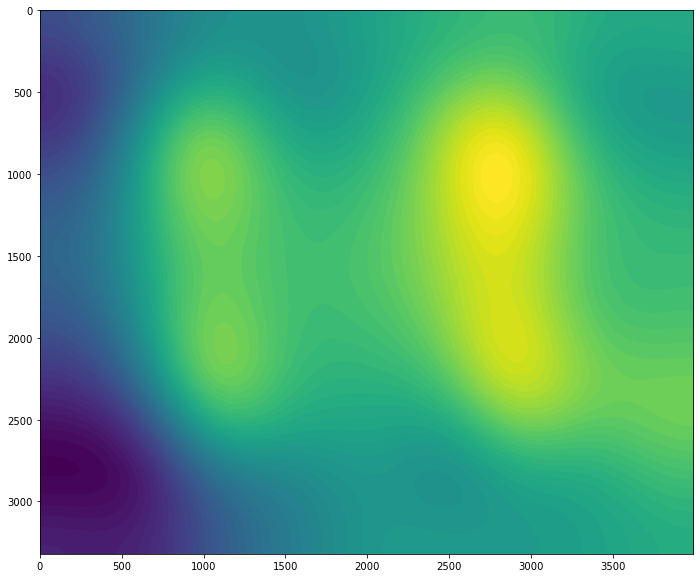

In [36]:
plt.imshow(bkgnd2)

In [37]:
subtr2 = subtr1 - bkgnd2

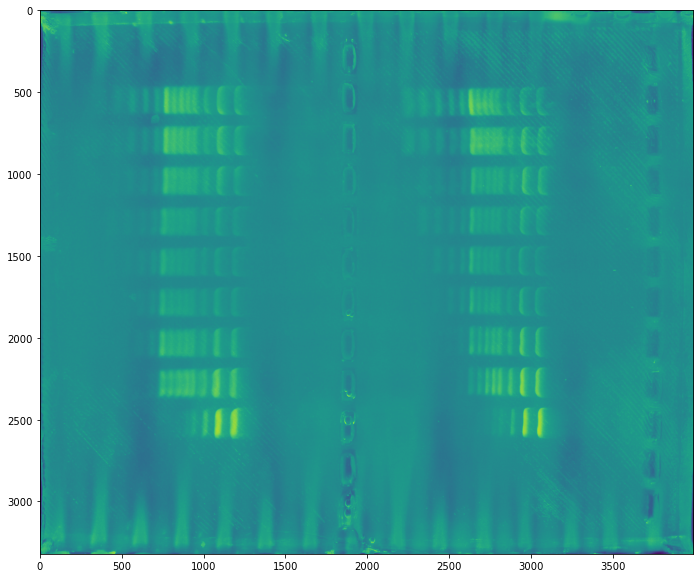

In [38]:
plt.imshow(subtr2)

In [39]:
mask = np.zeros(gray.shape, dtype="uint8")
roi_corners = np.array([[(2000, 500), (3500, 500), (3500, 600), (2000, 600)]], dtype=np.int32)
mask1 = cv2.fillPoly(mask, roi_corners, 255)
masked = cv2.bitwise_and(gray, mask1)

In [40]:
line1 = subtr2[500:600, 2000:3500]
line2 = subtr2[750:850, 2000:3500]

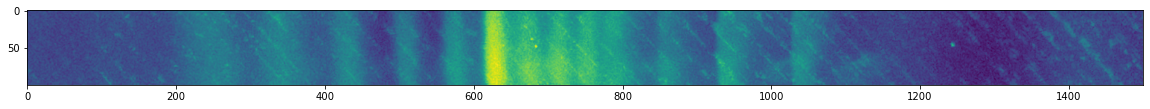

In [41]:
plt.imshow(line1)

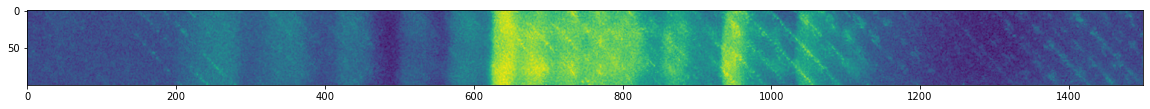

In [42]:
plt.imshow(line2)

In [43]:
subtr2.mean(axis=0)

array([-38.08674699, -35.30512048, -32.73554217, ..., -26.76596386,
       -30.38975904, -34.22981928])

In [44]:
profile = subtr2.mean(axis=1)

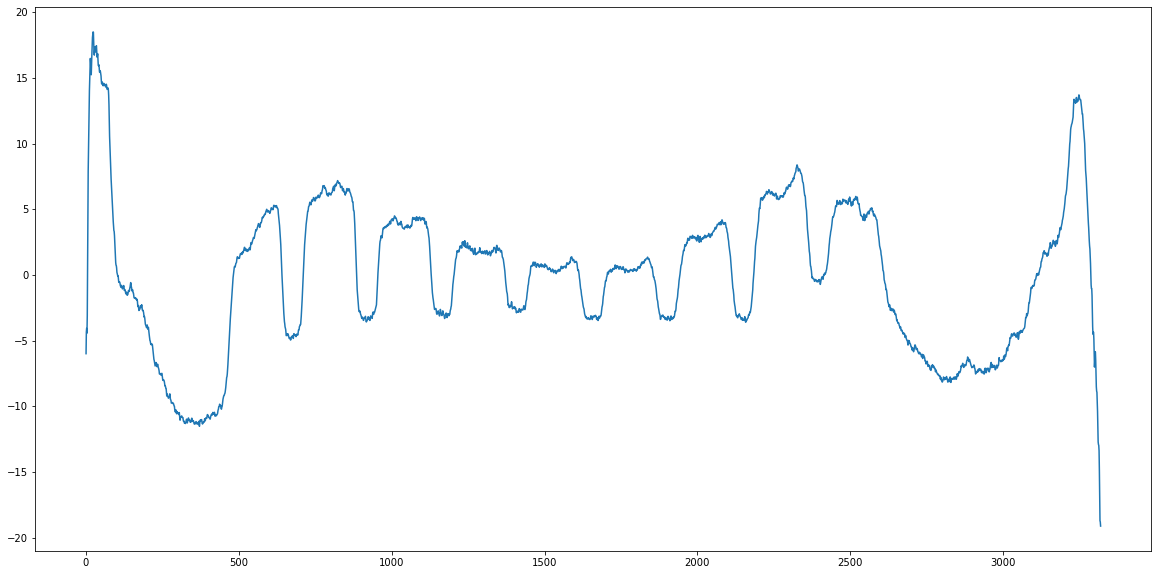

In [45]:
plt.plot(profile)

In [46]:
profile_smooth = scipy.signal.savgol_filter(profile, 51, 3)

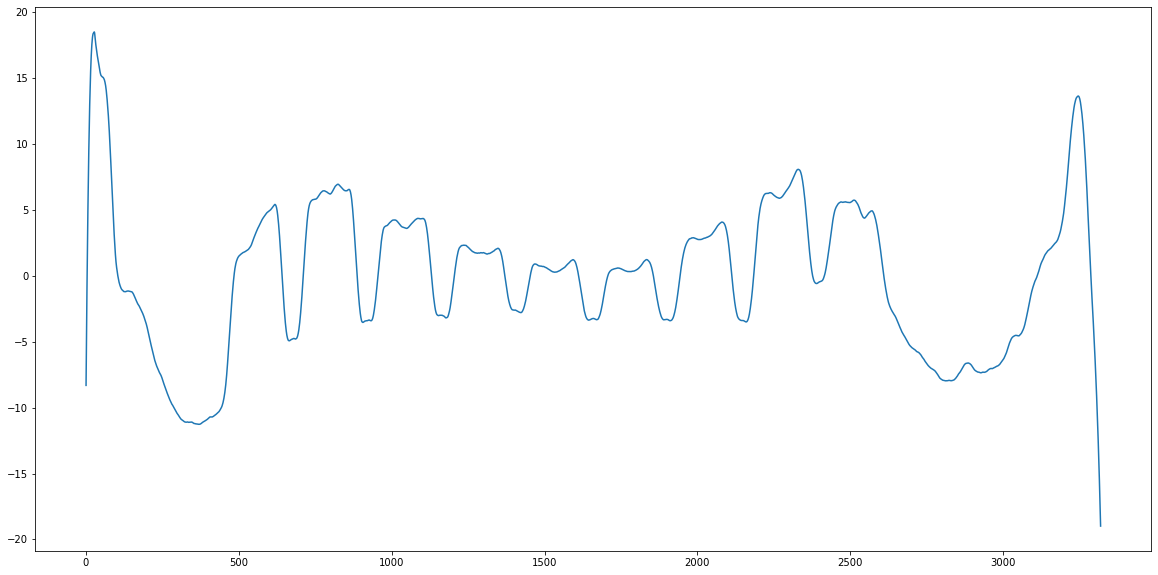

In [47]:
plt.plot(profile_smooth)

In [48]:
differ = np.diff(profile_smooth)

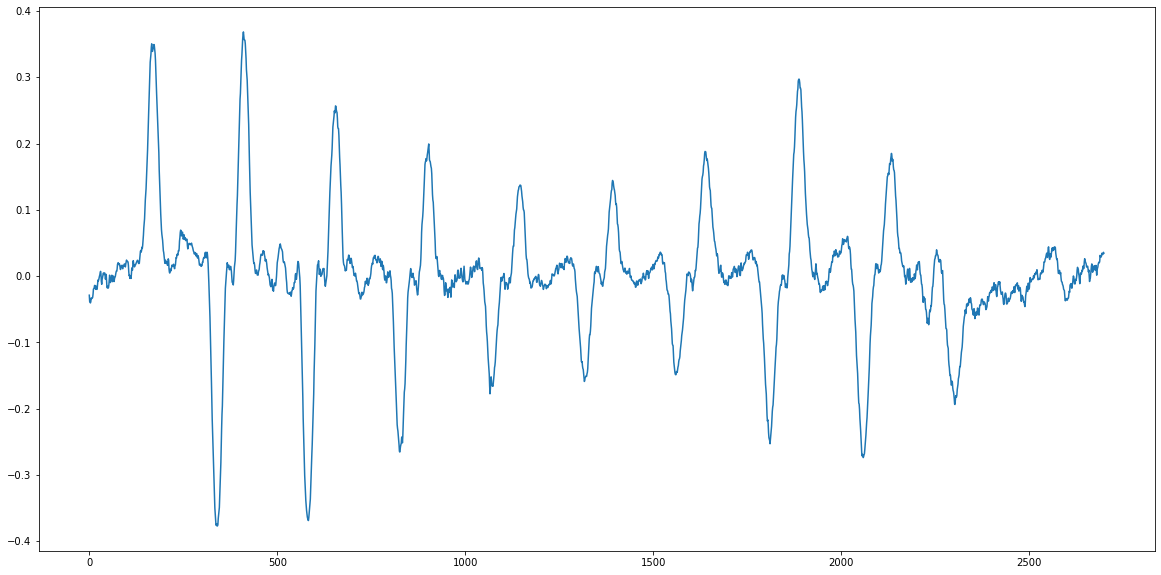

In [49]:
plt.plot(differ[300:3000])

In [50]:
differ[differ <= 0.1] = 0

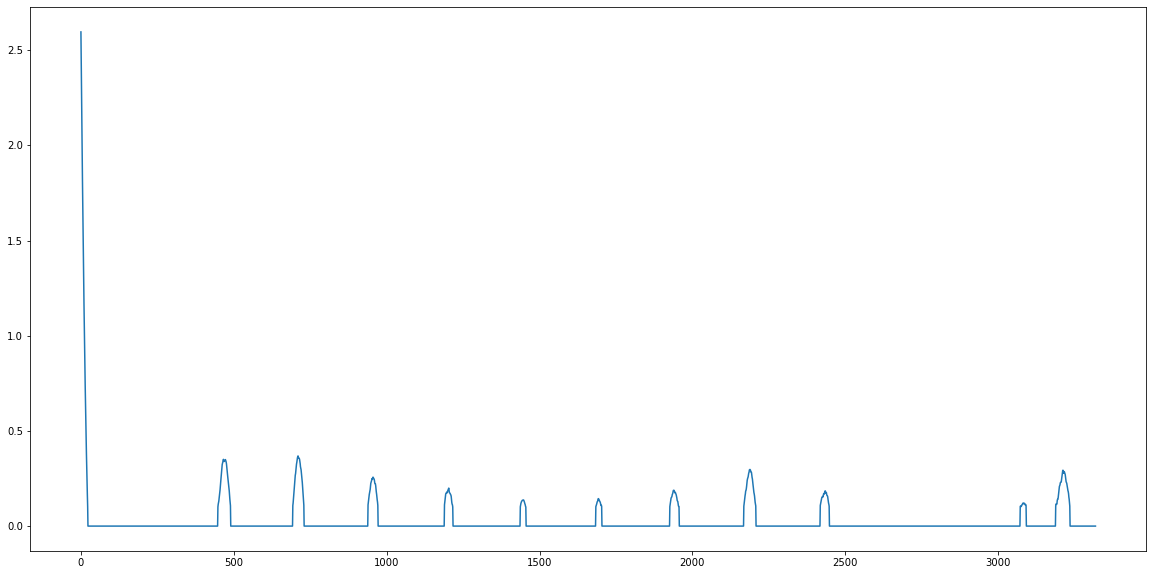

In [51]:
plt.plot(differ)

In [52]:
scipy.signal.argrelextrema(differ, np.greater)

(array([ 466,  472,  710,  952,  955, 1196, 1203, 1446, 1692, 1702, 1938,
        1944, 2188, 2426, 2430, 2434, 2437, 3074, 3081, 3085, 3090, 3190,
        3212, 3216], dtype=int64),)

In [53]:
peaks = [466, 710, 952, 1196, 1446, 1692, 1938, 2188, 2426]

In [54]:
peaks

[466, 710, 952, 1196, 1446, 1692, 1938, 2188, 2426]

In [55]:
def extractLine(gel, peak, peak_width, dist_from_peak, start_point, end_point):
    peak_start = peak + dist_from_peak
    peak_end = peak_start + peak_width
    line = subtr2[peak_start:peak_end, start_point:end_point]
    return line

In [56]:
def averageLine(line):
    return line.mean(axis=0)

In [57]:
def averageBackground(bk1, bk2):
    bk1mean = averageLine(bk1)
    bk2mean = averageLine(bk2)
    bk = (bk1mean + bk2mean)/2.0
    return bk

In [58]:
def bkgroundSubtract(line, background):
    return line -  background

In [59]:
def smoothLine(line, a=51, b=5):
    return scipy.signal.savgol_filter(line, a, b)

In [60]:
def calcAverageBandWidth(peaks):
    diff_array = np.diff(peaks)
    return int(diff_array.mean())

In [62]:
peaks.append(peaks[-1] + calcAverageBandWidth(peaks))

In [63]:
peaks

[466, 710, 952, 1196, 1446, 1692, 1938, 2188, 2426, 2671]

In [98]:
lines_list = []
for index, peak in enumerate(peaks):
    if index+1 < len(peaks):
        line = extractLine(subtr2, peak, 100, 40, 2150, 3100)
        bk1 = extractLine(subtr2, peak, 20, -30, 2150, 3100)
        bk2 = extractLine(subtr2, peaks[index+1], 20, -30, 2150, 3100)
        line_avg = averageLine(line)
        bkgnd_avg = averageBackground(bk1, bk2)
        line_no_bkg = bkgroundSubtract(line_avg, bkgnd_avg)
        line_smooth = smoothLine(line_no_bkg)
        lines_list.append(line_smooth)

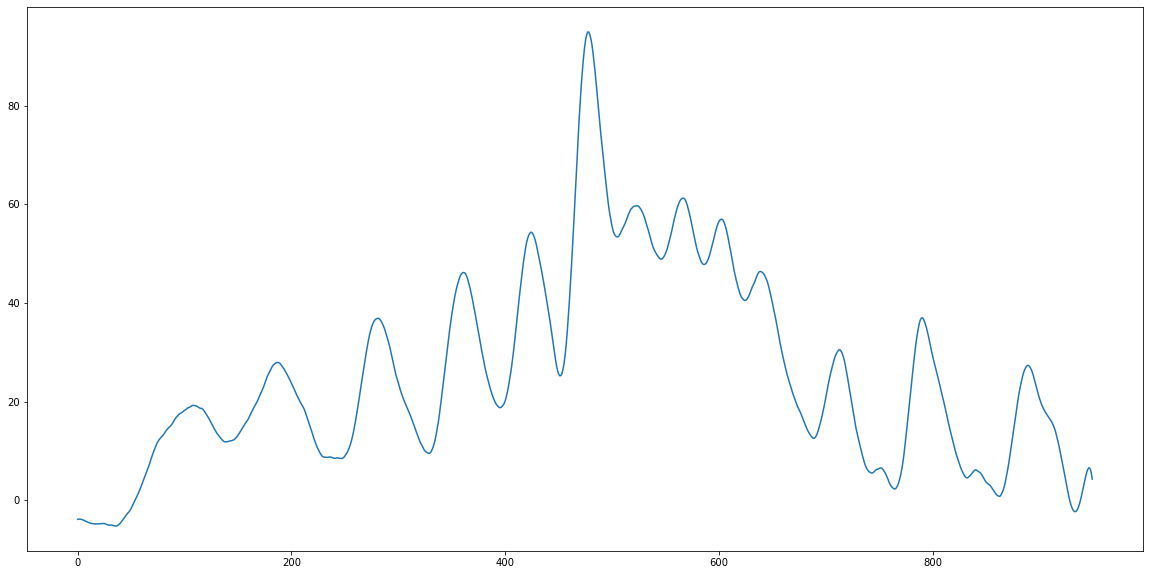

In [99]:
plt.plot(lines_list[0])

In [100]:
def genGap(length, width):
    return np.zeros((length, width))

In [101]:
def genGelLine(line, width, gap_width):
    line_img = np.zeros((line.shape[0], width))
    
    for i in range(width):
        line_img[:, i] = line[::-1]
    
    if gap_width > 0:
        gap = np.zeros((line.shape[0], gap_width))
        line_img = np.concatenate((gap, line_img, gap), axis=1)
    
    return line_img

In [112]:
def genGel(lines_list, width, gap_width):
    gel_lines_list = list(map(lambda x: genGelLine(x, width, gap_width), lines_list))
    gel = np.concatenate(gel_lines_list, axis=1)
    return gel

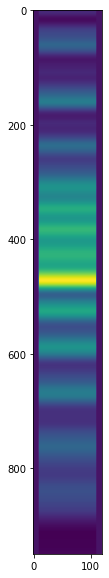

In [113]:
plt.imshow(genGelLine(lines_list[0], 100, 10))

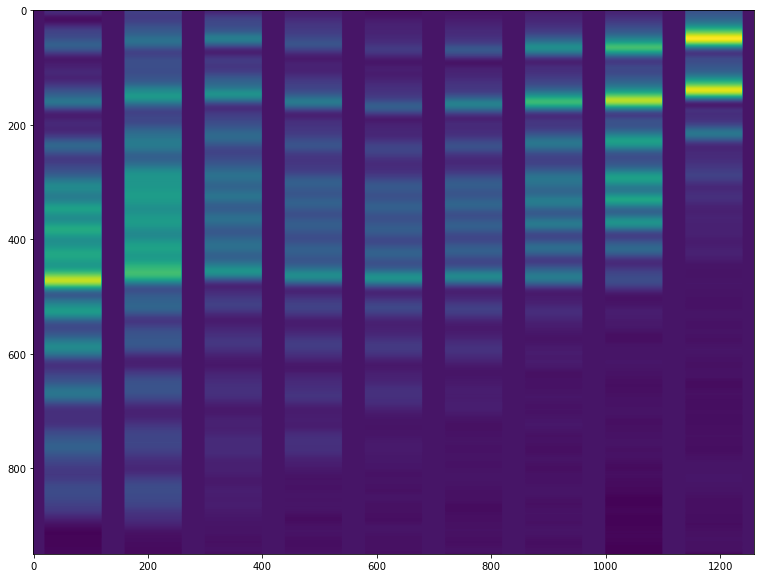

In [267]:
plt.imshow(genGel(lines_list, 100, 20))

In [268]:
def getMaxBandPos(line, start, finish):
    subline = line[start:finish]
    index = subline.argmax()
    index = start + index
    return index

In [269]:
band_index_list = list(map(lambda x: getMaxBandPos(x, 850, 1000), lines_list))

In [270]:
max_index = max(band_index_list)

In [271]:
scipy.ndimage.interpolation.shift(lines_list[0], band_index_list[0]-max_index, cval=0)

array([-4.53795091e+00, -4.60676332e+00, -4.66250342e+00, -4.70492206e+00,
       -4.73436965e+00, -4.75171647e+00, -4.75827278e+00, -4.75570906e+00,
       -4.74597625e+00, -4.73122589e+00, -4.71373038e+00, -4.69580314e+00,
       -4.67971887e+00, -4.66763369e+00, -4.66150539e+00, -4.78453604e+00,
       -4.84680820e+00, -4.91845505e+00, -5.01187261e+00, -5.01595444e+00,
       -4.98939449e+00, -4.99406254e+00, -5.06885111e+00, -5.10883791e+00,
       -5.18493421e+00, -5.19285617e+00, -5.11887910e+00, -4.98593472e+00,
       -4.79284993e+00, -4.57749155e+00, -4.25907360e+00, -3.96582831e+00,
       -3.70736254e+00, -3.38613938e+00, -3.09644506e+00, -2.77808595e+00,
       -2.52304388e+00, -2.31756974e+00, -2.01410972e+00, -1.63037072e+00,
       -1.15537425e+00, -6.50274257e-01, -2.34887352e-01,  1.93311931e-01,
        6.40945865e-01,  1.08903222e+00,  1.59500305e+00,  2.12542245e+00,
        2.66298284e+00,  3.23158528e+00,  3.85569845e+00,  4.42685683e+00,
        4.94057241e+00,  

In [272]:
aligned_lines = list(map(lambda x, y: shift(x, max_index-y, cval=0), lines_list, band_index_list))

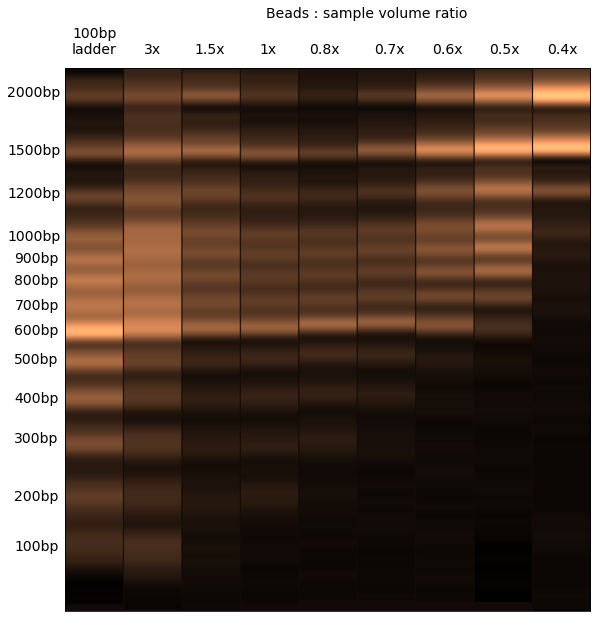

In [273]:
fig,ax = plt.subplots(1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
textstr = "Beads : sample volume ratio"
plt.gcf().text(0.47, 0.95, textstr, fontsize=14)
plt.gcf().text(0.335, 0.90, '100bp\nladder', fontsize=14)
plt.gcf().text(0.385, 0.90, '3x', fontsize=14)
plt.gcf().text(0.42, 0.90, '1.5x', fontsize=14)
plt.gcf().text(0.465, 0.90, '1x', fontsize=14)
plt.gcf().text(0.5, 0.90, '0.8x', fontsize=14)
plt.gcf().text(0.545, 0.90, '0.7x', fontsize=14)
plt.gcf().text(0.585, 0.90, '0.6x', fontsize=14)
plt.gcf().text(0.625, 0.90, '0.5x', fontsize=14)
plt.gcf().text(0.665, 0.90, '0.4x', fontsize=14)

plt.gcf().text(0.295, 0.21, '100bp', fontsize=14)
plt.gcf().text(0.295, 0.28, '200bp', fontsize=14)
plt.gcf().text(0.295, 0.36, '300bp', fontsize=14)
plt.gcf().text(0.295, 0.415, '400bp', fontsize=14)
plt.gcf().text(0.295, 0.47, '500bp', fontsize=14)
plt.gcf().text(0.295, 0.51, '600bp', fontsize=14)
plt.gcf().text(0.295, 0.545, '700bp', fontsize=14)
plt.gcf().text(0.295, 0.58, '800bp', fontsize=14)
plt.gcf().text(0.295, 0.61, '900bp', fontsize=14)
plt.gcf().text(0.290, 0.64, '1000bp', fontsize=14)
plt.gcf().text(0.290, 0.7, '1200bp', fontsize=14)
plt.gcf().text(0.290, 0.76, '1500bp', fontsize=14)
plt.gcf().text(0.290, 0.84, '2000bp', fontsize=14)
ax.imshow(genGel(aligned_lines, 100, 1), cmap='copper')

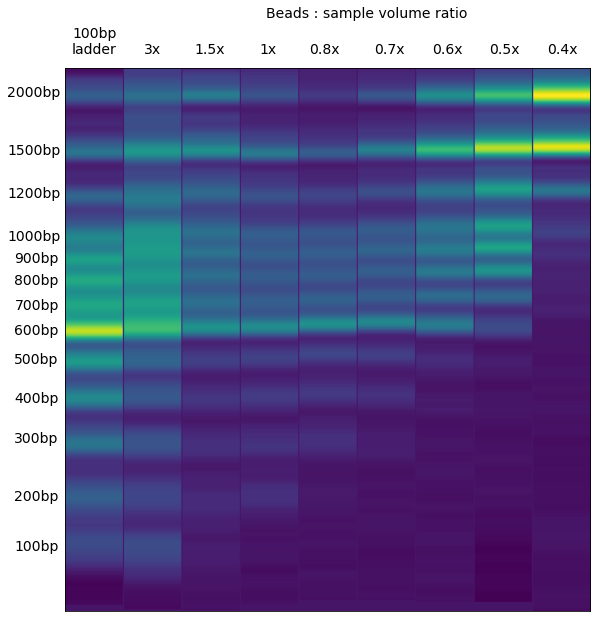

In [274]:
fig,ax = plt.subplots(1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
textstr = "Beads : sample volume ratio"
plt.gcf().text(0.47, 0.95, textstr, fontsize=14)
plt.gcf().text(0.335, 0.90, '100bp\nladder', fontsize=14)
plt.gcf().text(0.385, 0.90, '3x', fontsize=14)
plt.gcf().text(0.42, 0.90, '1.5x', fontsize=14)
plt.gcf().text(0.465, 0.90, '1x', fontsize=14)
plt.gcf().text(0.5, 0.90, '0.8x', fontsize=14)
plt.gcf().text(0.545, 0.90, '0.7x', fontsize=14)
plt.gcf().text(0.585, 0.90, '0.6x', fontsize=14)
plt.gcf().text(0.625, 0.90, '0.5x', fontsize=14)
plt.gcf().text(0.665, 0.90, '0.4x', fontsize=14)

plt.gcf().text(0.295, 0.21, '100bp', fontsize=14)
plt.gcf().text(0.295, 0.28, '200bp', fontsize=14)
plt.gcf().text(0.295, 0.36, '300bp', fontsize=14)
plt.gcf().text(0.295, 0.415, '400bp', fontsize=14)
plt.gcf().text(0.295, 0.47, '500bp', fontsize=14)
plt.gcf().text(0.295, 0.51, '600bp', fontsize=14)
plt.gcf().text(0.295, 0.545, '700bp', fontsize=14)
plt.gcf().text(0.295, 0.58, '800bp', fontsize=14)
plt.gcf().text(0.295, 0.61, '900bp', fontsize=14)
plt.gcf().text(0.290, 0.64, '1000bp', fontsize=14)
plt.gcf().text(0.290, 0.7, '1200bp', fontsize=14)
plt.gcf().text(0.290, 0.76, '1500bp', fontsize=14)
plt.gcf().text(0.290, 0.84, '2000bp', fontsize=14)
ax.imshow(genGel(aligned_lines, 100, 1))

In [134]:
aligned_lines

[array([-4.53795091e+00, -4.60676332e+00, -4.66250342e+00, -4.70492206e+00,
        -4.73436965e+00, -4.75171647e+00, -4.75827278e+00, -4.75570906e+00,
        -4.74597625e+00, -4.73122589e+00, -4.71373038e+00, -4.69580314e+00,
        -4.67971887e+00, -4.66763369e+00, -4.66150539e+00, -4.78453604e+00,
        -4.84680820e+00, -4.91845505e+00, -5.01187261e+00, -5.01595444e+00,
        -4.98939449e+00, -4.99406254e+00, -5.06885111e+00, -5.10883791e+00,
        -5.18493421e+00, -5.19285617e+00, -5.11887910e+00, -4.98593472e+00,
        -4.79284993e+00, -4.57749155e+00, -4.25907360e+00, -3.96582831e+00,
        -3.70736254e+00, -3.38613938e+00, -3.09644506e+00, -2.77808595e+00,
        -2.52304388e+00, -2.31756974e+00, -2.01410972e+00, -1.63037072e+00,
        -1.15537425e+00, -6.50274257e-01, -2.34887352e-01,  1.93311931e-01,
         6.40945865e-01,  1.08903222e+00,  1.59500305e+00,  2.12542245e+00,
         2.66298284e+00,  3.23158528e+00,  3.85569845e+00,  4.42685683e+00,
         4.9

In [373]:
lines_list = []
for peak in peaks:
    line = extractLine(subtr2, peak, 100, 40, 2150, 3100)
    lines_list.append(line)
    

In [469]:
bkgnd_peaks = peaks + [2700]
bkgnd_list = []
for bkgnd in bkgnd_peaks:
    line = extractLine(subtr2, bkgnd, 20, -30, 2150, 3100)
    bkgnd_list.append(line)

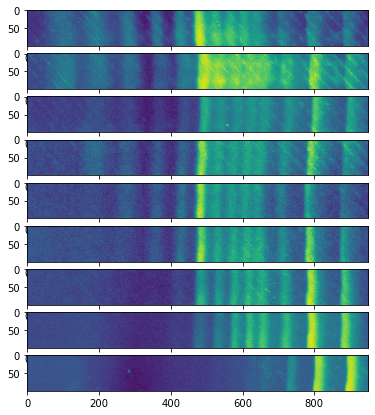

In [374]:
rows = 9
columns = 1
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.imshow(lines_list[0])
fig.add_subplot(rows, columns, 2)
plt.imshow(lines_list[1])
fig.add_subplot(rows, columns, 3)
plt.imshow(lines_list[2])
fig.add_subplot(rows, columns, 4)
plt.imshow(lines_list[3])
fig.add_subplot(rows, columns, 5)
plt.imshow(lines_list[4])
fig.add_subplot(rows, columns, 6)
plt.imshow(lines_list[5])
fig.add_subplot(rows, columns, 7)
plt.imshow(lines_list[6])
fig.add_subplot(rows, columns, 8)
plt.imshow(lines_list[7])
fig.add_subplot(rows, columns, 9)
plt.imshow(lines_list[8])

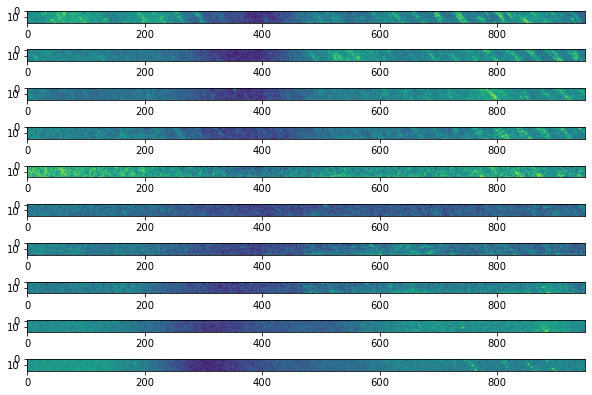

In [470]:
rows = 10
columns = 1
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.imshow(bkgnd_list[0])
fig.add_subplot(rows, columns, 2)
plt.imshow(bkgnd_list[1])
fig.add_subplot(rows, columns, 3)
plt.imshow(bkgnd_list[2])
fig.add_subplot(rows, columns, 4)
plt.imshow(bkgnd_list[3])
fig.add_subplot(rows, columns, 5)
plt.imshow(bkgnd_list[4])
fig.add_subplot(rows, columns, 6)
plt.imshow(bkgnd_list[5])
fig.add_subplot(rows, columns, 7)
plt.imshow(bkgnd_list[6])
fig.add_subplot(rows, columns, 8)
plt.imshow(bkgnd_list[7])
fig.add_subplot(rows, columns, 9)
plt.imshow(bkgnd_list[8])
fig.add_subplot(rows, columns, 10)
plt.imshow(bkgnd_list[9])

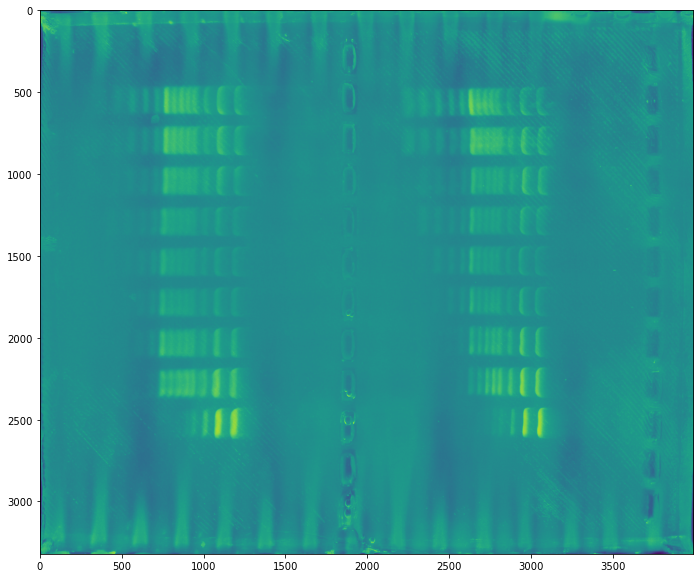

In [375]:
plt.imshow(subtr2)

In [478]:
line1 = lines_list[0].mean(axis=0)

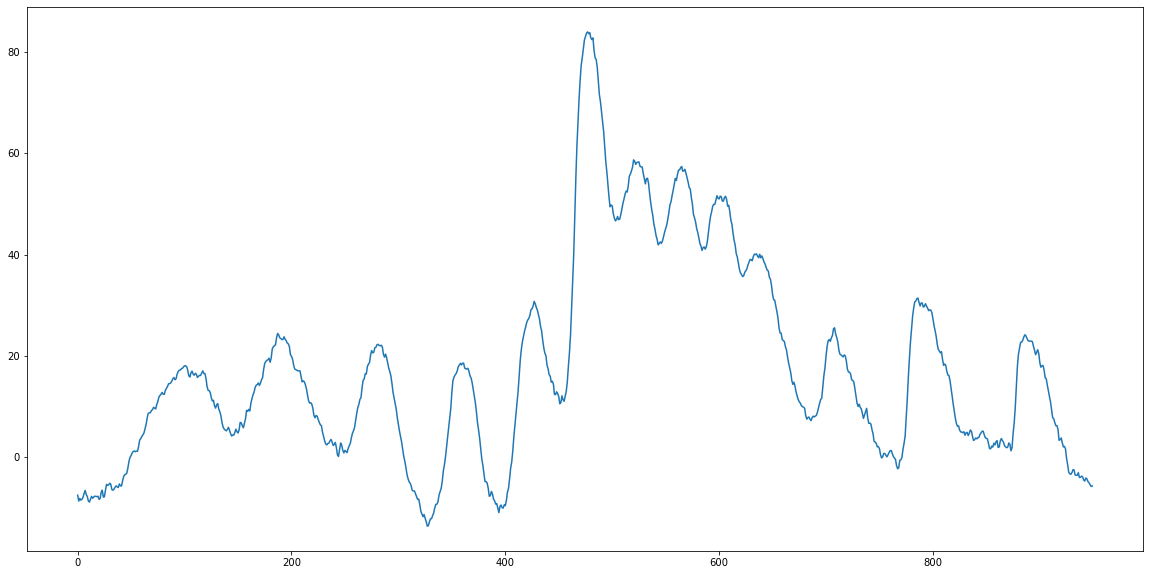

In [479]:
plt.plot(line1)

In [480]:
line1 = scipy.signal.savgol_filter(line1, 51, 5)

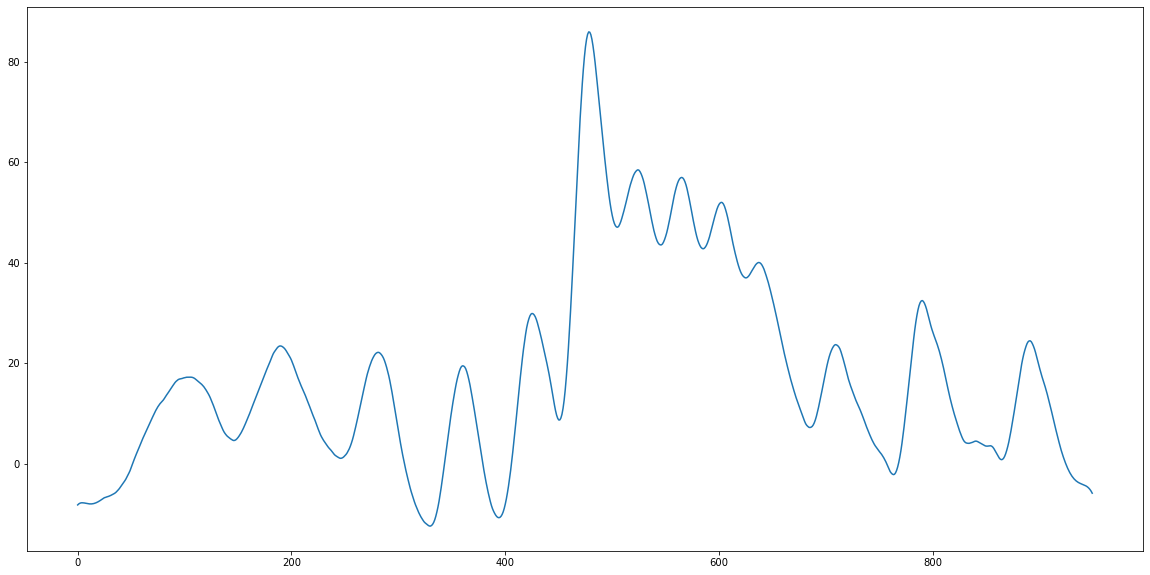

In [481]:
plt.plot(line1)

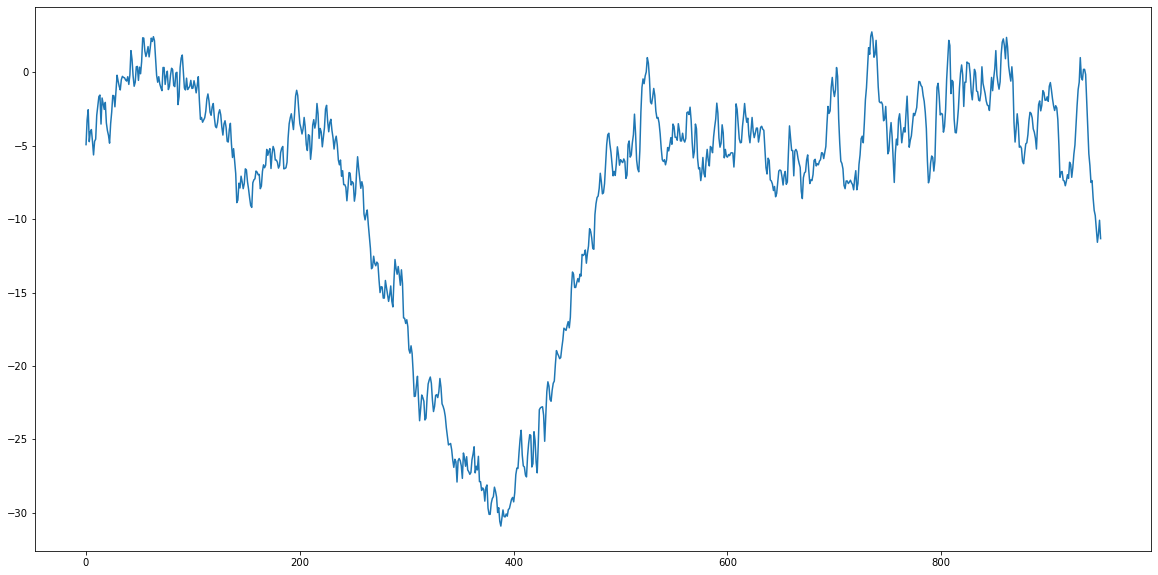

In [475]:
bkgnd1 = bkgnd_list[0].mean(axis=0)
bkgnd2 = bkgnd_list[1].mean(axis=0)
bkgnd1 = (bkgnd1 + bkgnd2)/2.0
plt.plot(bkgnd1)

In [476]:
bkgnd1 = scipy.signal.savgol_filter(bkgnd1, 51, 5)

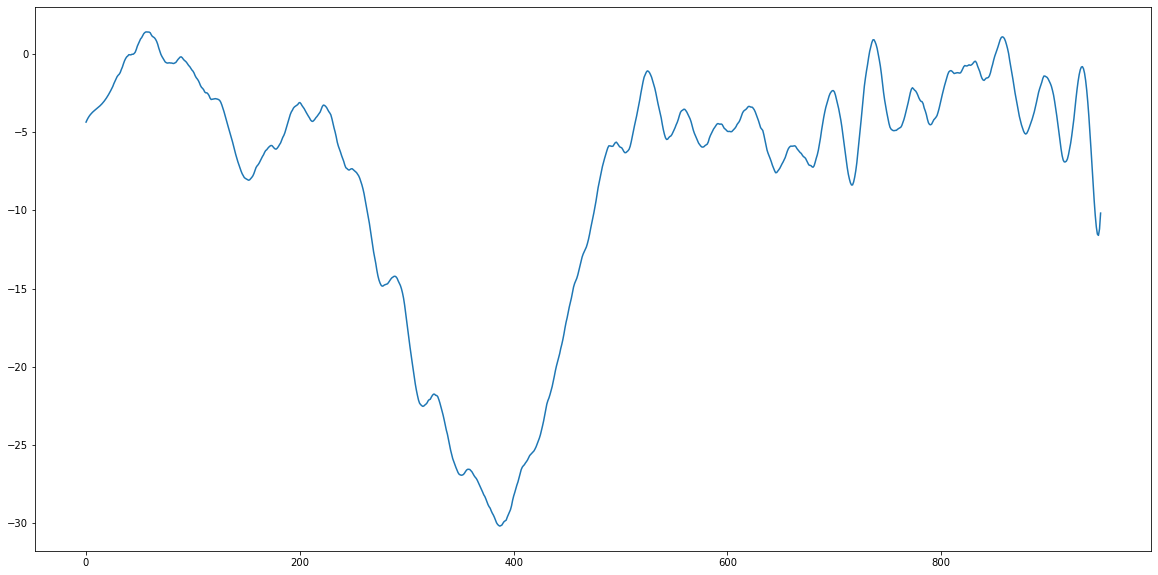

In [477]:
plt.plot(bkgnd1)

In [482]:
line1_nobkgnd = line1 - bkgnd1

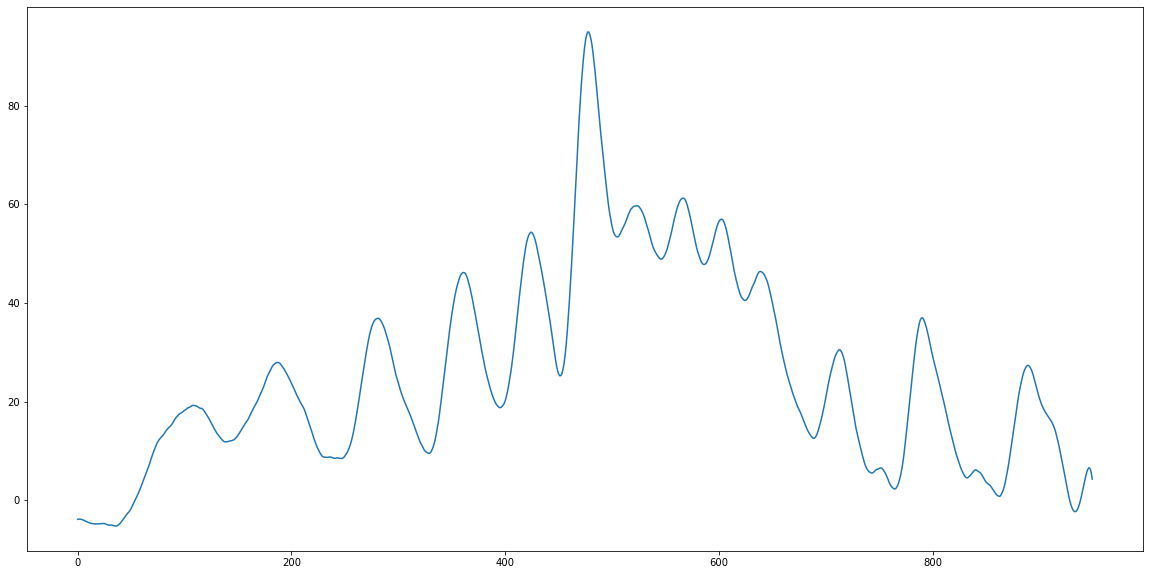

In [483]:
plt.plot(line1_nobkgnd)

In [461]:
line1 = line1 * (60 / line1[850:].max() * 1.0)

In [456]:
line1 = np.interp(line1, (line1.min(), line1[850:].max()), (0, 255))

In [484]:
line1_img = np.zeros((line1_nobkgnd.shape[0], 100))

In [485]:
for i in range(line1_img.shape[1]):
    line1_img[:, i] = line1[::-1]

In [486]:
line1_img[0].shape

(100,)

In [487]:
line1_img.shape

(950, 100)

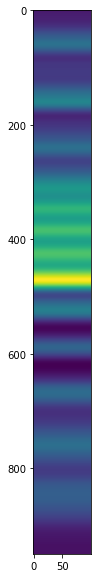

In [488]:
plt.imshow(line1_img)